In [1]:
from typing import List
from itertools import combinations
import numpy as np
import dask.dataframe as dd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
dir = "./data/random/fixed/"
real = dd.read_parquet(dir+"main.parquet", columns=["spec","variant","real.tests", "real.downs", "size", "clocks"])
squished = dd.read_parquet(dir+"squished.parquet", columns=["spec","variant","approx.tests", "approx.downs", "limit.tests", "limit.downs"])
opti = dd.read_parquet(dir+"opti/init_weights.min_front.parquet", index=["spec"],columns=["variant","comb", "real.tests", "real.downs"])
squished = squished.groupby(["spec", "variant"]).max()

real_max = real.groupby(["spec", "variant"]).max()

In [3]:
comparison_squished = real_max.join(squished, on=["spec", "variant"]).compute()

### Difference percentage limit vs real max

<AxesSubplot:xlabel='spec'>

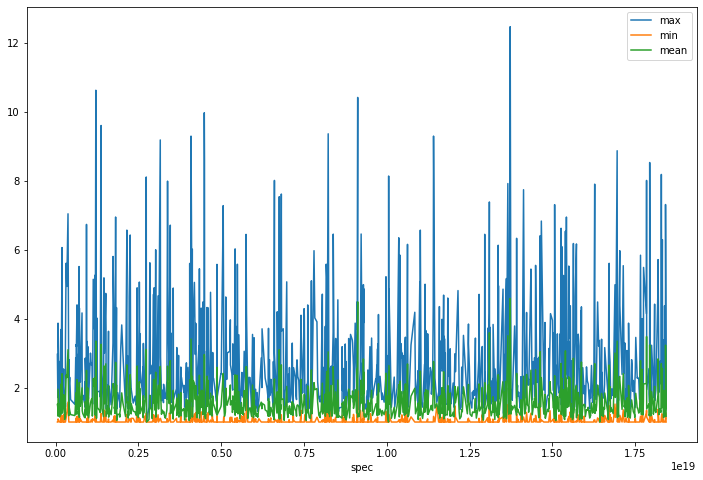

In [4]:
(comparison_squished["limit.tests"]/comparison_squished["real.tests"]).groupby("spec").agg(["max", "min", "mean"]).plot(figsize=(12,8))

### Specifications that fails to be approximated correctly

In [5]:
comparison_squished[comparison_squished["approx.tests"] < comparison_squished["real.tests"]]

real.tests  real.downs  size  clocks  \
spec                 variant                                         
136899624668707323   25              239         105     6       7   
                     27              239         105     6       7   
                     28              195          91     6       7   
                     29              195          91     6       7   
                     33              439         161     6       7   
...                                  ...         ...   ...     ...   
18392748334620384884 111              86          39     5       5   
18432962492680829874 0                74          30     4       5   
                     2                74          30     4       5   
                     6                73          29     4       5   
                     12               73          29     4       5   

                              approx.tests  approx.downs  limit.tests  \
spec                 variant                                            
136899624668707323   25                231            99          255   
                     27                231            99          255   
                     28                183            84          219   
                     29                183            84          219   
                     33                423           189          471   
...                                    ...           ...          ...   
18392748334620384884 111                82            36          152   
18432962492680829874 0                  70            28          104   
                     2                  70            28          104   
                     6                  69            27           81   
                     12                 69            27           81   

                              limit.downs  
spec                 variant               
136899624668707323   25               117  
                     27               117  
                     28               105  
                     29               105  
                     33               225  
...                                   ...  
18392748334620384884 111               76  
18432962492680829874 0                 44  
                     2                 44  
                     6                 33  
                     12                33  

[35696 rows x 8 columns]

### Raw limit vs real max percentage

<AxesSubplot:xlabel='spec,variant'>

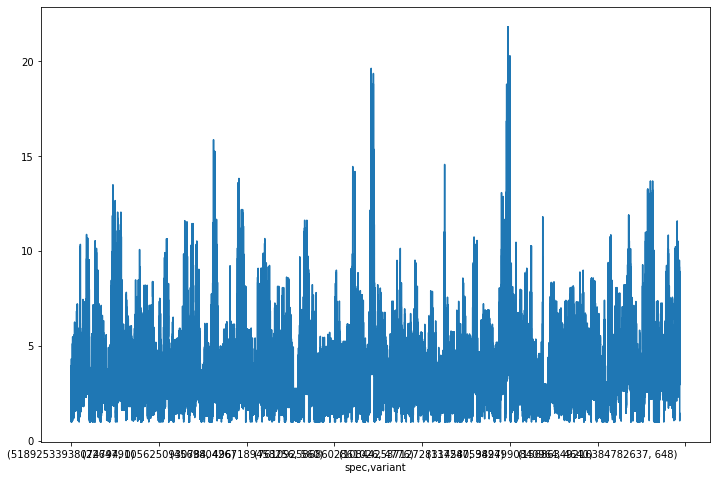

In [6]:
(comparison_squished["limit.downs"]/comparison_squished["real.downs"]).plot(figsize=(12,8))

In [7]:
opti_max = opti.groupby("spec").max()
real_statistics = real_max.groupby("spec").aggregate(["min", "max", "mean"])
compare = real_statistics.join(opti_max)
comparison_opti = compare.compute()

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


### Specification complexity range evolution (natural order)

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='spec'>

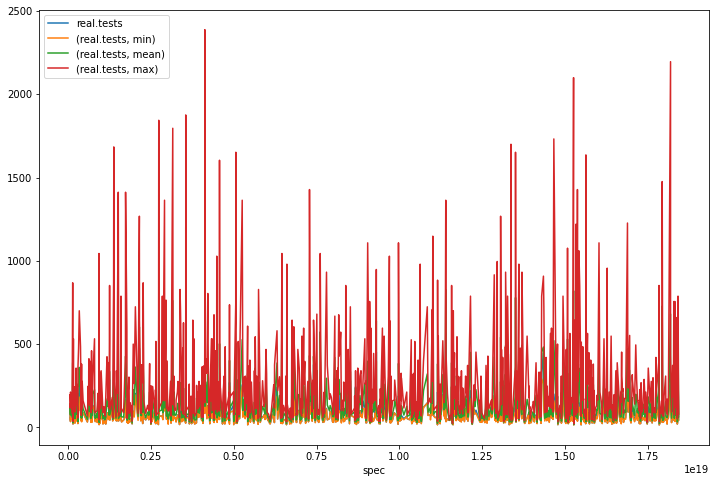

In [8]:
comparison_opti[["real.tests", ("real.tests", "min"), ("real.tests", "mean"), ("real.tests", "max")]].plot(figsize=(12, 8))

### Specification complexity range evolution (size)

<AxesSubplot:xlabel='size', ylabel='diff'>

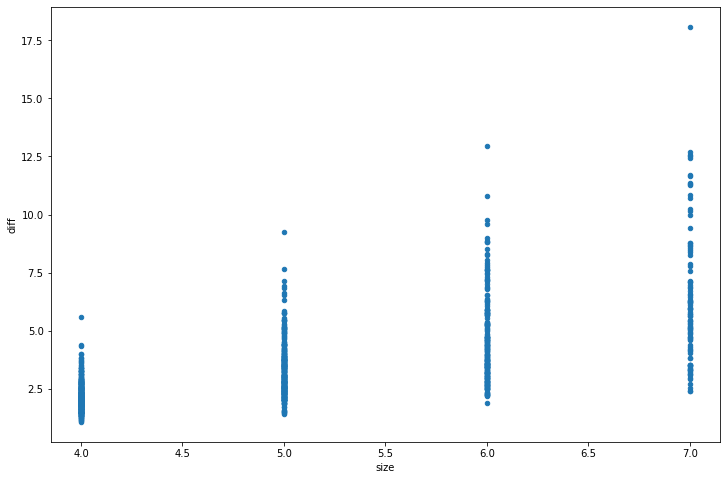

In [9]:
comparison_opti2 = comparison_opti.sort_values(("clocks", "max"))
comparison_opti2["diff"] = comparison_opti2[("real.tests", "max")]/comparison_opti2[("real.tests", "min")]
comparison_opti2["size"] = comparison_opti2[("size","max")]
comparison_opti2["clocks"] = comparison_opti2[("clocks","max")]
comparison_opti2.sort_values("size").plot.scatter(x="size", y="diff",figsize=(12, 8))

<AxesSubplot:xlabel='clocks', ylabel='diff'>

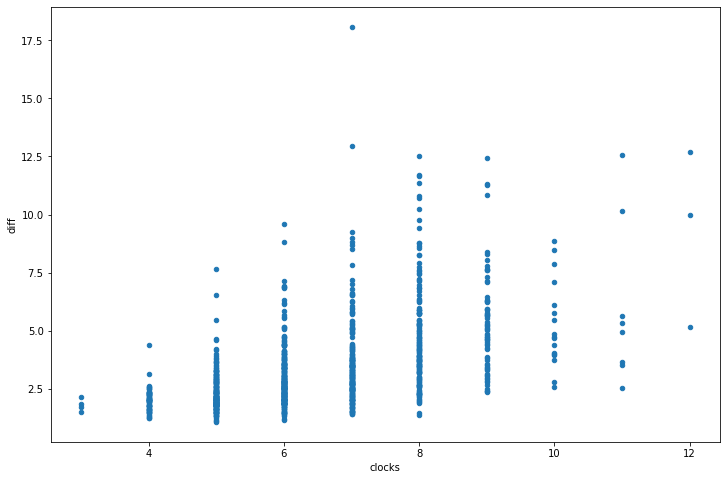

In [10]:
comparison_opti2.sort_values("clocks").plot.scatter(x="clocks", y="diff",figsize=(12, 8))

### All failed to optimize specifications

In [11]:
comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]]


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,comb,real.tests,real.downs
spec,,,,,,,,,,,,,,,,
679281214975076496,84,148,113.333333,36,52,43.333333,4,4,4.0,5,5,5.0,0,7,116,44
989202492737245960,71,147,105.266667,35,57,45.800000,5,5,5.0,6,6,6.0,0,0,110,45
2462869174627452095,84,148,113.333333,36,52,43.333333,4,4,4.0,6,6,6.0,3,3,116,44
7341688890593459552,124,260,180.733333,56,92,70.400000,5,5,5.0,5,5,5.0,36,15,184,70
7721503904424502091,72,189,112.050000,27,64,40.950000,6,6,6.0,8,8,8.0,186,0,127,42
8139600420793084657,37,51,44.083333,12,17,14.500000,4,4,4.0,4,4,4.0,3,0,48,15
8678028512220747566,148,340,237.600000,68,116,90.400000,5,5,5.0,6,6,6.0,10,15,244,92
11606009959643938094,18,24,19.833333,8,12,9.166667,4,4,4.0,6,6,6.0,2,1,20,10
17710486030002683782,59,118,86.200000,20,39,28.000000,5,5,5.0,6,6,6.0,33,0,96,31


### Percentage of badly optimized specifications

In [12]:
len(comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]])/len(comparison_opti)

0.01

### Scatter plot of permutations' real test values for each specification

<AxesSubplot:xlabel='spec', ylabel='real.tests'>

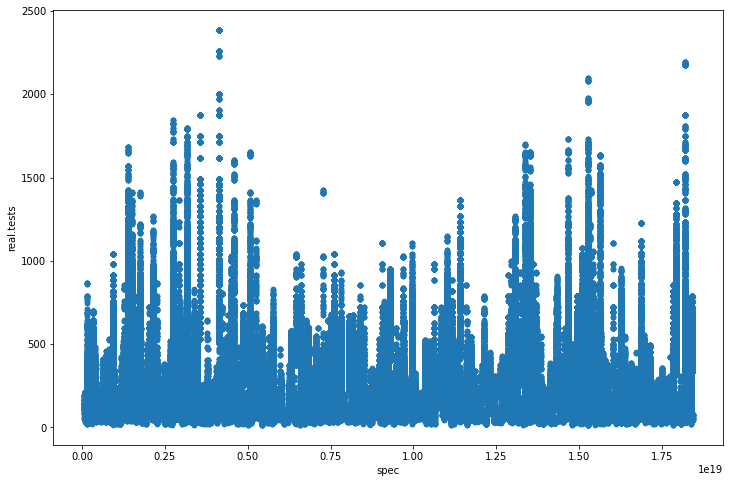

In [13]:
frame = real_max.compute()
frame.reset_index(inplace=True)
frame.plot.scatter(x="spec", y="real.tests", figsize=(12, 8))

### Relative scatter plot

In [14]:
relative_dist = real_max.compute().reset_index(level="variant").join(real_statistics.compute(), on="spec")
relative_dist

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)"
spec,,,,,,,,,,,,,,,,,
51892533938074794,0,124,44,5,5,104,196,141.40,38,64,48.600000,5,5,5.0,5,5,5.0
51892533938074794,1,132,48,5,5,104,196,141.40,38,64,48.600000,5,5,5.0,5,5,5.0
51892533938074794,2,140,48,5,5,104,196,141.40,38,64,48.600000,5,5,5.0,5,5,5.0
51892533938074794,3,140,48,5,5,104,196,141.40,38,64,48.600000,5,5,5.0,5,5,5.0
51892533938074794,4,164,56,5,5,104,196,141.40,38,64,48.600000,5,5,5.0,5,5,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18432962492680829874,19,62,28,4,5,44,80,63.75,21,34,27.416667,4,4,4.0,5,5,5.0
18432962492680829874,20,76,32,4,5,44,80,63.75,21,34,27.416667,4,4,4.0,5,5,5.0
18432962492680829874,21,54,25,4,5,44,80,63.75,21,34,27.416667,4,4,4.0,5,5,5.0


In [15]:
def scale_reals(row):
    new_rows = dict()
    test_min = row[("real.tests", "min")]
    test_max = row[("real.tests", "max")]
    if test_max == test_min:
        new_rows["rel_tests"] = 0
    else:
        new_rows["rel_tests"] = (row["real.tests"] - test_min) / (test_max - test_min)
    down_min = row[("real.downs", "min")]
    down_max = row[("real.downs", "max")]
    if down_min == down_max:
        new_rows["rel_downs"] = 0
    else:
        new_rows["rel_downs"] = (row["real.downs"] - down_min) / (down_max - down_min)
    new_rows["size"] = row["size"]
    new_rows["clocks"] = row["clocks"]
    return new_rows
relative_dist = relative_dist.apply(scale_reals, axis=1, result_type='expand')
relative_dist

,rel_tests,rel_downs,size,clocks
spec,,,,
51892533938074794,0.217391,0.230769,5.0,5.0
51892533938074794,0.304348,0.384615,5.0,5.0
51892533938074794,0.391304,0.384615,5.0,5.0
51892533938074794,0.391304,0.384615,5.0,5.0
51892533938074794,0.652174,0.692308,5.0,5.0
...,...,...,...,...
18432962492680829874,0.500000,0.538462,4.0,5.0
18432962492680829874,0.888889,0.846154,4.0,5.0
18432962492680829874,0.277778,0.307692,4.0,5.0


In [16]:
relative_dist4 = relative_dist[relative_dist["size"] == 4]

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

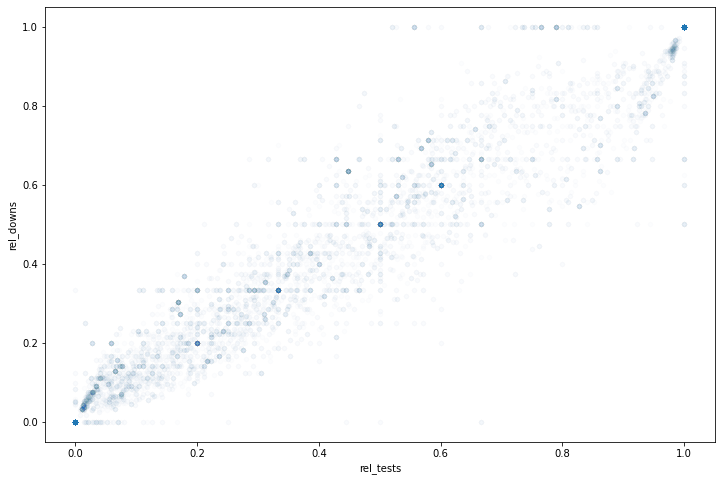

In [17]:
relative_dist4.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.01, figsize=(12, 8))


<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

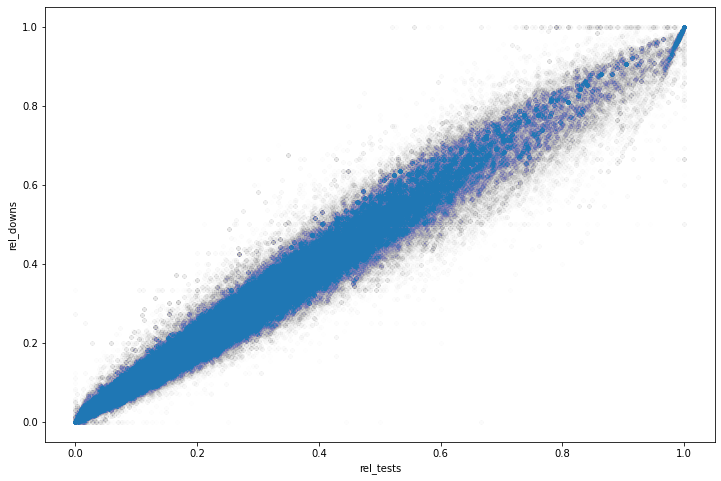

In [18]:
relative_dist.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.005, figsize=(12, 8))


In [19]:
num_points = relative_dist.groupby("spec").aggregate(len).sort_values("rel_tests")

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

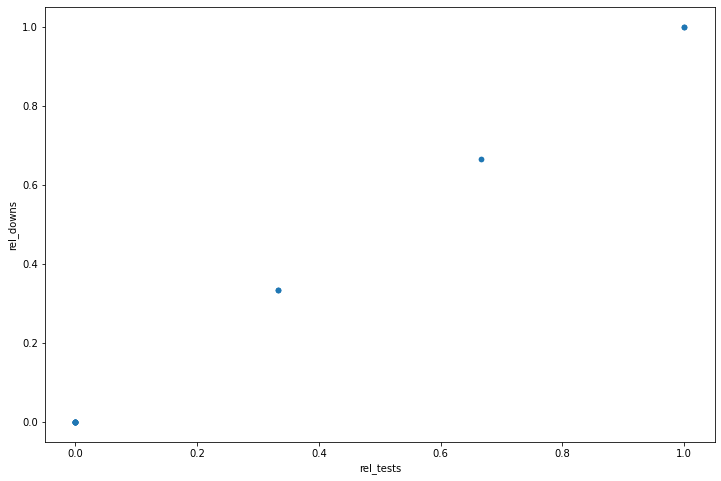

In [20]:
relative_dist.loc[num_points.index[2]].plot.scatter(x="rel_tests", y="rel_downs", figsize=(12, 8))

In [21]:
import os

all_methods_comp = real_statistics
methods = []
for file in os.listdir(dir+"/opti"):
     filename = os.fsdecode(file)
     if filename.endswith(".parquet"):
         table = dd.read_parquet(dir+"opti/"+filename, index=["spec"],columns=["real.tests"])
         table = table.groupby("spec").max()
         method = filename.replace(".parquet", "")
         table = table.rename(columns={"real.tests": method})
         methods.append(method)
         all_methods_comp = all_methods_comp.join(table)
     else:
         continue
all_methods_comp = all_methods_comp.compute()
all_methods_comp

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)",...,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,heatmap.dijkstra,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,,,,,,
51892533938074794,104,196,141.400000,38,64,48.600000,5,5,5.0,5,...,112,104,104,135,104,112,104,112,104,104
61760932481443283,51,116,82.166667,21,40,29.083333,4,4,4.0,5,...,88,51,51,88,51,51,51,51,51,51
71494259075619179,34,148,74.166667,16,60,31.833333,4,4,4.0,7,...,44,36,36,44,36,36,34,44,36,36
71545674059426822,55,212,115.416667,21,70,40.850000,6,6,6.0,6,...,68,60,84,68,60,61,81,82,60,65
118600122405516986,46,84,63.916667,24,36,31.083333,4,4,4.0,6,...,48,48,48,46,48,52,46,46,48,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18392748334620384884,67,194,122.000000,32,76,49.600000,5,5,5.0,5,...,114,68,68,114,68,68,67,68,68,114
18393744352728927060,20,52,32.583333,10,26,15.916667,4,4,4.0,5,...,32,23,23,23,20,23,20,23,23,20
18414416888391821950,52,82,63.500000,21,33,25.750000,4,4,4.0,4,...,61,52,57,61,52,52,52,61,52,52


In [22]:
def diffs(row):
    new_row = dict()
    mean = row[("real.tests", "mean")]
    for i,c in enumerate(methods, start=1):
        new_row[c] = int(row[c] < mean or row[("real.tests", "min")] == row[("real.tests", "max")])
    return new_row
diffs_comp = all_methods_comp.copy()
diffs_comp = diffs_comp.apply(diffs, axis=1, result_type='expand')
diffs_comp

,sort_min_weights,tricost.dijkstra,init_weights.dijkstra,networkx.min_front,heatmap.min_front,random,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,heatmap.dijkstra,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,
51892533938074794,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
61760932481443283,1,1,1,0,1,0,0,1,1,0,1,1,1,1,1,1
71494259075619179,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
71545674059426822,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
118600122405516986,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18392748334620384884,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
18393744352728927060,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
18414416888391821950,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Percentage of good optimized specifications by method

In [23]:
diffs_comp.apply(sum, axis=0).sort_values()/len(diffs_comp)

random                    0.560
sort_min_weights          0.695
networkx.dijkstra         0.878
networkx.min_front        0.906
heatmap.dijkstra          0.938
random.dijkstra           0.942
heatmap.min_front         0.951
random.min_front          0.955
min_out.tree_width        0.961
min_out.tree_depth        0.978
min_out.min_front         0.981
min_out.dijkstra          0.985
tricost.dijkstra          0.989
init_weights.dijkstra     0.990
init_weights.min_front    0.990
tricost.min_front         0.990
dtype: float64

### Visualisation of optimization coverage

<AxesSubplot:xlabel='spec'>

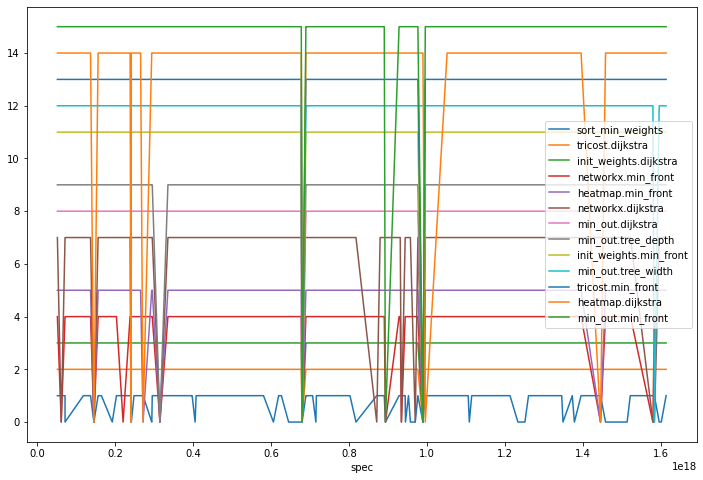

In [24]:
def scale_methods(row):
    new_row = dict()
    for i,c in enumerate(methods, start=1):
        if "random" in c:
            continue
        new_row[c] = i*row[c]
    return new_row
without_rand = diffs_comp.apply(scale_methods, axis=1, result_type='expand')
without_rand.iloc[:100].plot(figsize=(12, 8))

### Cumulative coverage

<AxesSubplot:xlabel='spec'>

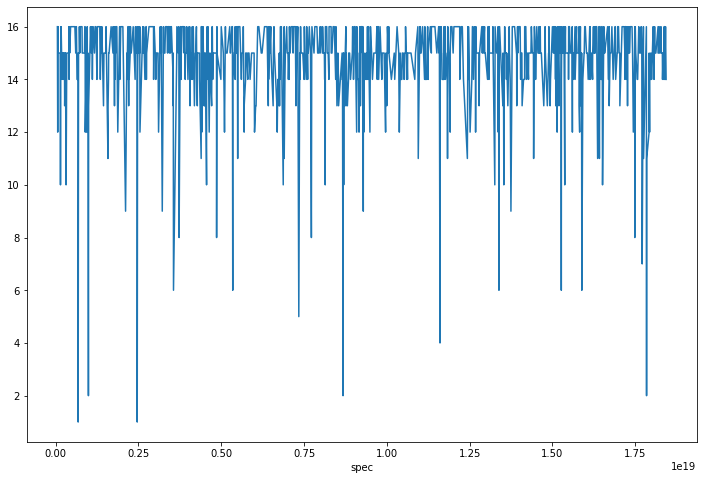

In [25]:
cumulative_comp = diffs_comp.apply(sum, axis=1)
cumulative_comp.plot(figsize=(12, 8))

### Uncovered specifications

In [26]:
cumulative_comp[cumulative_comp == 0]

Series([], dtype: int64)

In [27]:
starting = real_max.compute().reset_index(level="variant")
starting = starting[starting["variant"] == 0]
gain = starting.join(all_methods_comp)
gain = gain[(gain[("real.tests", "max")]/gain[("real.tests", "min")])>1.05]
gain

,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)",...,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,heatmap.dijkstra,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,,,,,,
51892533938074794,0,124,44,5,5,104,196,141.400000,38,64,...,112,104,104,135,104,112,104,112,104,104
61760932481443283,0,87,29,4,5,51,116,82.166667,21,40,...,88,51,51,88,51,51,51,51,51,51
71494259075619179,0,44,20,4,7,34,148,74.166667,16,60,...,44,36,36,44,36,36,34,44,36,36
71545674059426822,0,116,43,6,6,55,212,115.416667,21,70,...,68,60,84,68,60,61,81,82,60,65
118600122405516986,0,46,24,4,6,46,84,63.916667,24,36,...,48,48,48,46,48,52,46,46,48,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18392748334620384884,0,114,46,5,5,67,194,122.000000,32,76,...,114,68,68,114,68,68,67,68,68,114
18393744352728927060,0,51,25,4,5,20,52,32.583333,10,26,...,32,23,23,23,20,23,20,23,23,20
18414416888391821950,0,61,26,4,4,52,82,63.500000,21,33,...,61,52,57,61,52,52,52,61,52,52


### Gain in percentage relative to input specification

<AxesSubplot:ylabel='Frequency'>

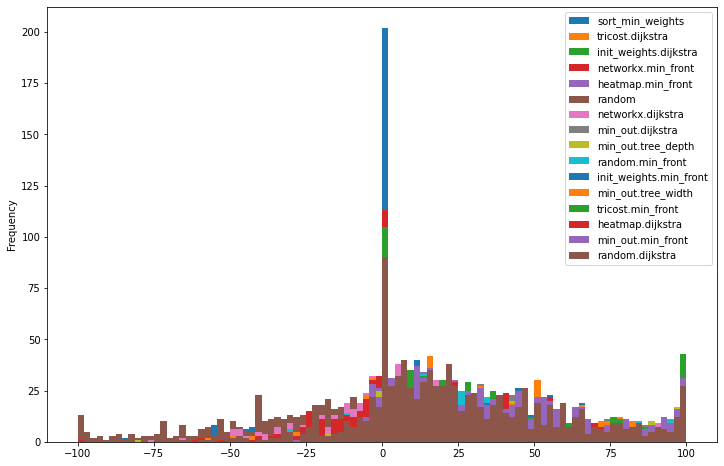

In [28]:
def gains_minus_start(row):
    new_row = dict()
    real = float(row["real.tests"])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (real - float(row[c])) / diff * 100
    return new_row
gain_from_start = gain.apply(gains_minus_start, axis=1, result_type='expand')
gain_from_start.plot.hist(bins=96, alpha=1,figsize=(12, 8))

### Gain in percentage relative to input specification (specific method)

<AxesSubplot:ylabel='Frequency'>

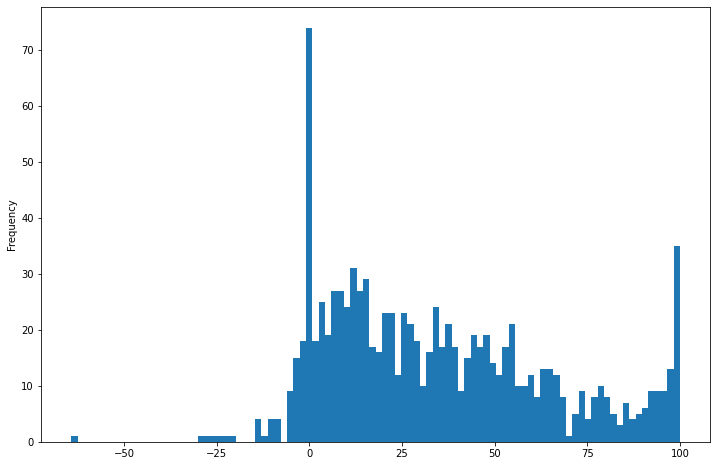

In [29]:
gain_from_start["init_weights.min_front"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

### What are the 0 specs?

In [30]:
strange_0_specs = gain_from_start[["init_weights.min_front", ]][gain_from_start["init_weights.min_front"] == 0]
strange_0_specs = strange_0_specs.join(real_statistics.compute()).join(starting)
strange_0_specs

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,init_weights.min_front,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,real.tests,real.downs,size,clocks
spec,,,,,,,,,,,,,,,,,,
271626161294329481,0.0,68,148,116.000000,32,52,44.000000,4,4,4.0,5,5,5.0,0,68,32,4,5
679281214975076496,0.0,84,148,113.333333,36,52,43.333333,4,4,4.0,5,5,5.0,0,116,44,4,5
944415596913719977,0.0,72,140,91.500000,38,64,46.000000,4,4,4.0,5,5,5.0,0,72,38,4,5
989202492737245960,0.0,71,147,105.266667,35,57,45.800000,5,5,5.0,6,6,6.0,0,110,45,5,6
1114303331962597534,0.0,32,82,54.750000,17,34,24.250000,4,4,4.0,4,4,4.0,0,34,17,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17222558772387316205,0.0,58,132,84.833333,29,50,37.083333,4,4,4.0,6,6,6.0,0,59,30,4,6
17633427594395212697,0.0,26,66,39.000000,10,24,15.750000,4,4,4.0,4,4,4.0,0,27,11,4,4
17698724222019452952,0.0,38,88,56.916667,16,34,22.250000,4,4,4.0,6,6,6.0,0,40,18,4,6


<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

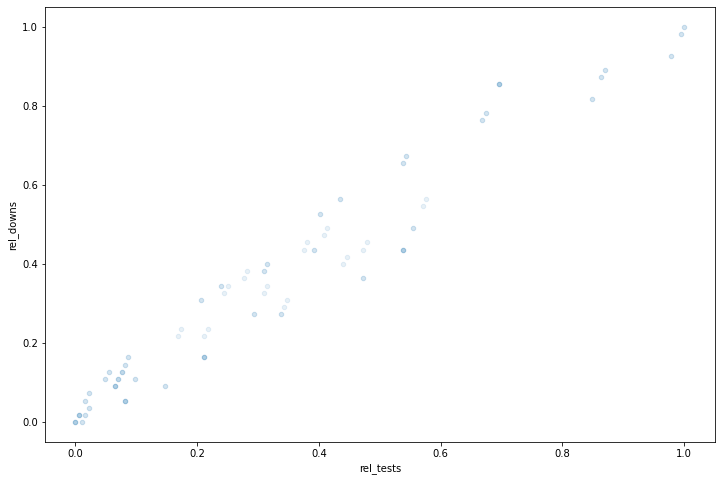

In [31]:
relative_dist.loc[strange_0_specs.index[-1]].plot.scatter(x="rel_tests", y="rel_downs", alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<AxesSubplot:ylabel='Frequency'>

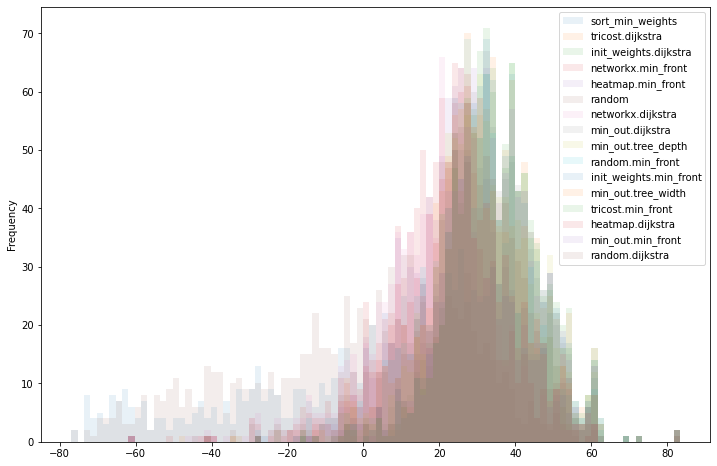

In [32]:
def gains_from_mean(row):
    new_row = dict()
    mean = float(row[("real.tests", "mean")])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (mean - float(row[c])) / diff * 100
    return new_row
gain_from_mean = all_methods_comp.apply(gains_from_mean, axis=1, result_type='expand')
gain_from_mean.plot.hist(bins=96, alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<AxesSubplot:ylabel='Frequency'>

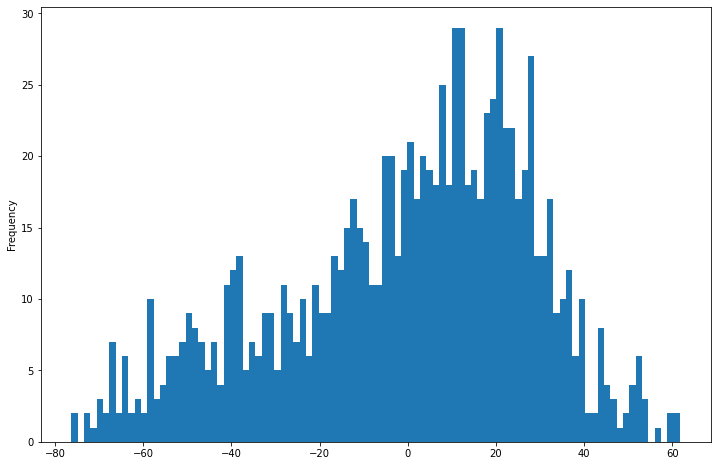

In [33]:
gain_from_mean["random"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

<AxesSubplot:ylabel='Frequency'>

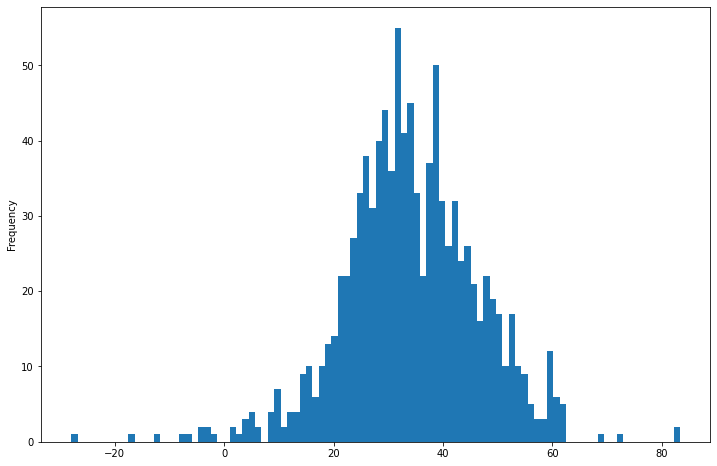

In [34]:
gain_from_mean["init_weights.min_front"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

### Gain characteristics per method

In [35]:
gain_from_mean.aggregate(["mean", "std"], axis=0).transpose().sort_values("mean", ascending=False)

,mean,std
tricost.min_front,34.546011,12.273150
init_weights.dijkstra,34.337926,12.271084
init_weights.min_front,34.147153,12.370260
tricost.dijkstra,34.097856,12.486589
min_out.min_front,32.939138,13.213283
min_out.dijkstra,32.668301,13.311006
min_out.tree_depth,31.195862,13.401690
random.min_front,28.014601,14.696136
min_out.tree_width,27.985404,14.184888
random.dijkstra,26.579374,16.260527


### Complexity grow speed (by clocks)

<AxesSubplot:xlabel='clocks'>

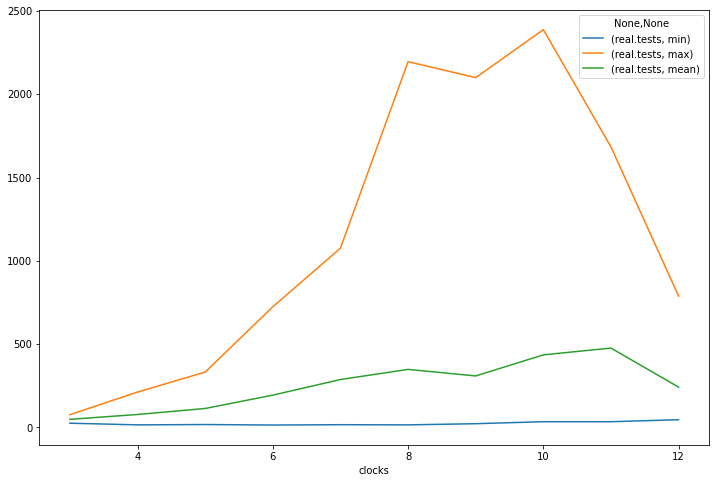

In [36]:
real_max[["clocks", "real.tests"]].groupby("clocks").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

### Complexity grow speed (by size)

<AxesSubplot:xlabel='size'>

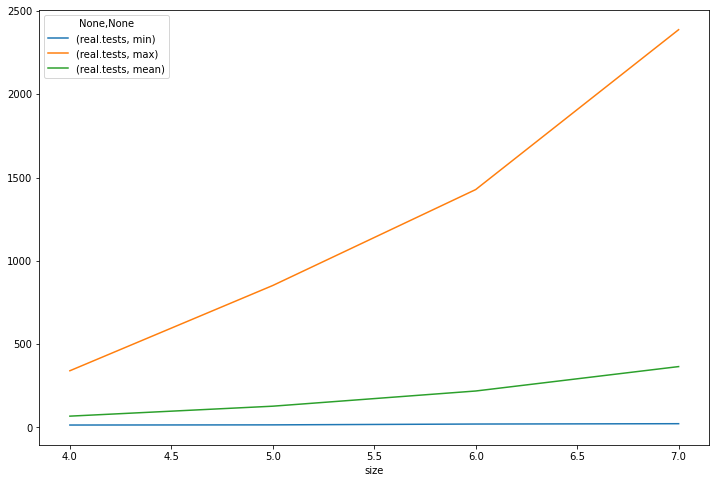

In [37]:
real_max[["size", "real.tests"]].groupby("size").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

In [38]:
comparison_size_clock = comparison_squished.copy()
comparison_size_clock["approx.tests"] = comparison_size_clock["approx.tests"].astype(np.int64)
comparison_size_clock["diff_appr_real"] = ((comparison_size_clock["approx.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock["diff_limit_real"] = ((comparison_size_clock["limit.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock

real.tests  real.downs  size  clocks  \
spec                 variant                                         
51892533938074794    0               124          44     5       5   
                     1               132          48     5       5   
                     2               140          48     5       5   
                     3               140          48     5       5   
                     4               164          56     5       5   
...                                  ...         ...   ...     ...   
18432962492680829874 19               62          28     4       5   
                     20               76          32     4       5   
                     21               54          25     4       5   
                     22               46          23     4       5   
                     23               45          22     4       5   

                              approx.tests  approx.downs  limit.tests  \
spec                 variant                                            
51892533938074794    0                 124            56          140   
                     1                 132            60          132   
                     2                 140            60          172   
                     3                 188            72          236   
                     4                 164            68          164   
...                                    ...           ...          ...   
18432962492680829874 19                 62            27           68   
                     20                 76            31           96   
                     21                 54            25           72   
                     22                 46            22           56   
                     23                 45            22           60   

                              limit.downs  diff_appr_real  diff_limit_real  
spec                 variant                                                
51892533938074794    0                 68        0.000000         0.129032  
                     1                 68        0.000000         0.000000  
                     2                 76        0.000000         0.228571  
                     3                 92        0.342857         0.685714  
                     4                 76        0.000000         0.000000  
...                                   ...             ...              ...  
18432962492680829874 19                36        0.000000         0.096774  
                     20                44        0.000000         0.263158  
                     21                36        0.000000         0.333333  
                     22                32        0.000000         0.217391  
                     23                32        0.000000         0.333333  

[693600 rows x 10 columns]

In [39]:
comparison_size_clock.groupby("size").aggregate("count")
comparison_size_clock.groupby("clocks").aggregate("count")


,real.tests,real.downs,clocks,approx.tests,approx.downs,limit.tests,limit.downs,diff_appr_real,diff_limit_real
size,,,,,,,,,
4,9600,9600,9600,9600,9600,9600,9600,9600,9600
5,36000,36000,36000,36000,36000,36000,36000,36000,36000
6,144000,144000,144000,144000,144000,144000,144000,144000,144000
7,504000,504000,504000,504000,504000,504000,504000,504000,504000


,real.tests,real.downs,size,approx.tests,approx.downs,limit.tests,limit.downs,diff_appr_real,diff_limit_real
clocks,,,,,,,,,
3,96,96,96,96,96,96,96,96,96
4,2688,2688,2688,2688,2688,2688,2688,2688,2688
5,12888,12888,12888,12888,12888,12888,12888,12888,12888
6,65040,65040,65040,65040,65040,65040,65040,65040,65040
7,133440,133440,133440,133440,133440,133440,133440,133440,133440
8,222528,222528,222528,222528,222528,222528,222528,222528,222528
9,156480,156480,156480,156480,156480,156480,156480,156480,156480
10,49920,49920,49920,49920,49920,49920,49920,49920,49920
11,35400,35400,35400,35400,35400,35400,35400,35400,35400


### Growth speed of difference of real and approximate complexities (by size)

<AxesSubplot:xlabel='size'>

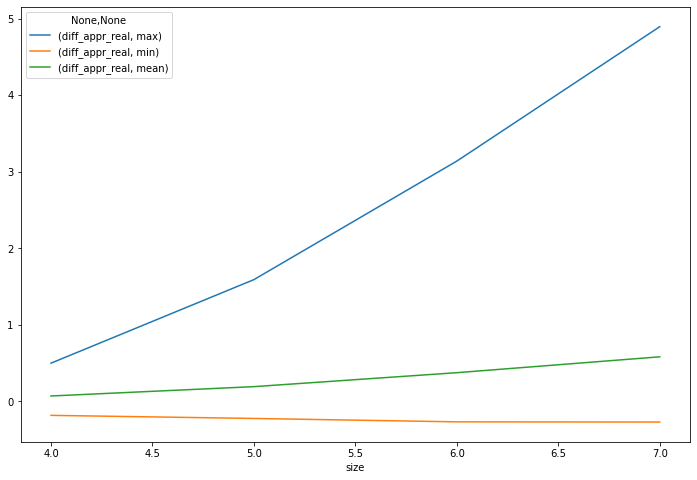

In [40]:
comparison_size_clock[["size", "diff_appr_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='size'>

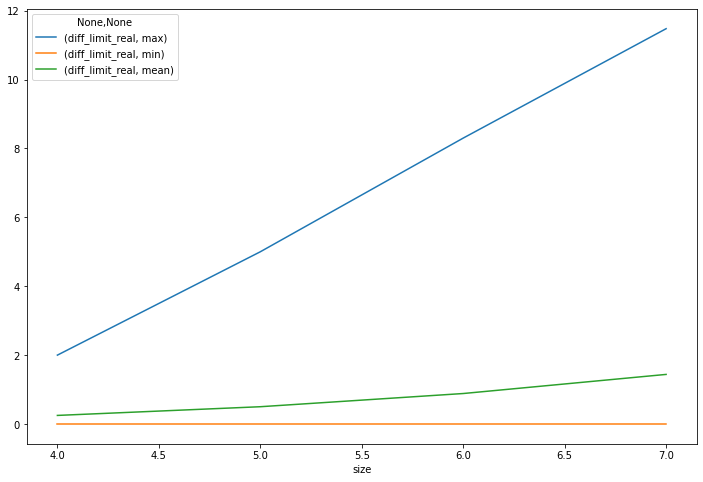

In [41]:
comparison_size_clock[["size", "diff_limit_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))


### Growth speed of difference of real and approximate complexities (by clock)

<AxesSubplot:xlabel='clocks'>

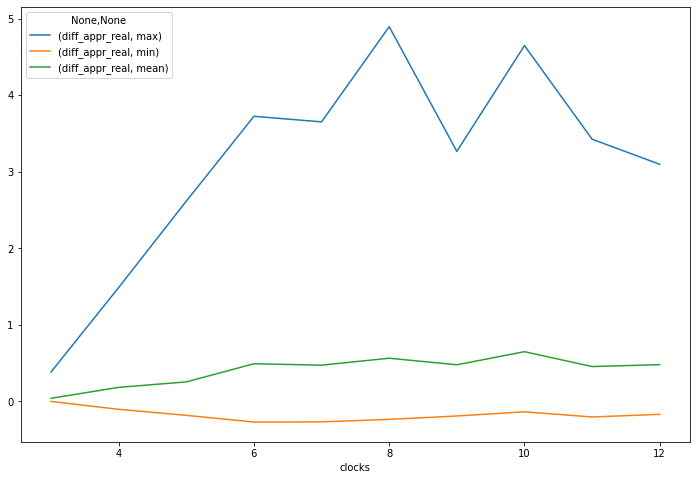

In [42]:
comparison_size_clock[["clocks", "diff_appr_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='clocks'>

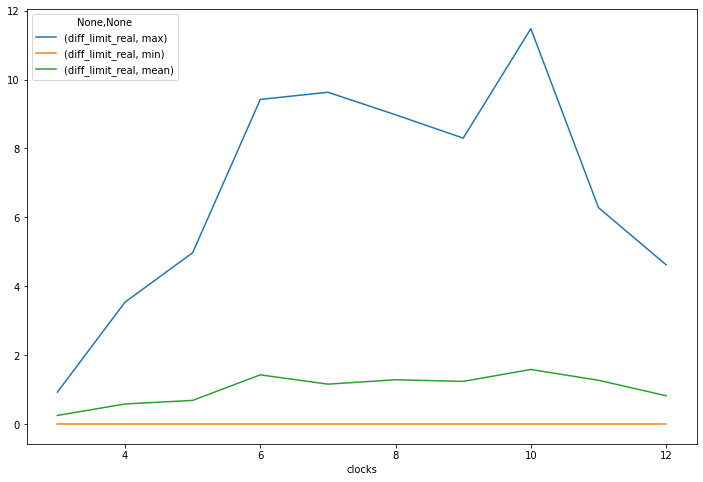

In [43]:
comparison_size_clock[["clocks", "diff_limit_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

### Check if approximations allow specification comparison

In [44]:
check_order = comparison_squished[["real.tests", "approx.tests"]].reset_index(level="variant").drop("variant", axis=1).groupby("spec").aggregate(list)
check_order

,real.tests,approx.tests
spec,,
51892533938074794,"[124, 132, 140, 140, 164, 148, 124, 132, 140, ...","[124, 132, 140, 188, 164, 196, 124, 132, 140, ..."
61760932481443283,"[87, 87, 87, 55, 87, 55, 88, 88, 92, 82, 116, ...","[87, 87, 87, 71, 87, 71, 88, 88, 92, 82, 164, ..."
71494259075619179,"[44, 60, 68, 148, 84, 148, 42, 58, 34, 34, 58,...","[44, 60, 84, 148, 116, 148, 42, 58, 34, 34, 58..."
71545674059426822,"[116, 124, 148, 188, 156, 188, 92, 100, 84, 84...","[188, 188, 172, 188, 188, 188, 100, 100, 84, 8..."
118600122405516986,"[46, 50, 56, 80, 66, 82, 48, 52, 52, 64, 60, 6...","[46, 50, 80, 80, 90, 82, 48, 52, 52, 64, 60, 6..."
...,...,...
18392748334620384884,"[114, 114, 144, 160, 160, 166, 114, 114, 120, ...","[114, 114, 184, 160, 208, 166, 114, 114, 120, ..."
18393744352728927060,"[51, 51, 33, 23, 33, 23, 52, 52, 36, 32, 36, 3...","[63, 63, 33, 27, 33, 27, 64, 64, 36, 32, 36, 3..."
18414416888391821950,"[61, 64, 61, 58, 82, 76, 60, 63, 75, 67, 62, 5...","[61, 64, 61, 58, 106, 100, 60, 63, 102, 87, 62..."


In [45]:
def order_holds(orig: List[int], aprox: List[int]) -> float:
    candidates = list(zip(orig, aprox))
    hold_times = 0
    count = 0
    for (lorig, laprox), (rorig, raprox) in combinations(candidates, 2):
        ok = (lorig < rorig and laprox < raprox) or \
          (lorig > rorig and laprox > raprox) or \
          (lorig == rorig and laprox == raprox)
        hold_times += int(ok)
        count +=1
    return hold_times/count

check_order["holds"] = check_order.apply(lambda row: order_holds(row["real.tests"], row["approx.tests"]), axis=1)
check_order.holds.mean()

0.86709638655042